## CNN (ResNet) with pooling hyperparameter optimization

We'll try to find a good set of hyperparameters for a standard CNN setup.

In [1]:
import logging
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

from hyperopt import Trials, STATUS_OK, tpe
from hyperopt.pyll.base import scope
from hyperas import optim
from hyperas.distributions import choice, uniform, quniform
from hyperas.utils import eval_hyperopt_space

import tools.train as train
import tools.models as models
import tools.plot as plot

# Suppress tensorflow warnings about internal deprecations
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Count data
files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
# Add a dimension for "channels"
for key in inputs:
    inputs[key] = tf.expand_dims(inputs[key], axis=2)
train.class_count(df)

Using TensorFlow backend.



Train set
Count of each class
Classes
0.0    72471
1.0     2223
2.0     5788
3.0      641
4.0     6431
dtype: int64

Test set
Count of each class
Classes
0.0    18118
1.0      556
2.0     1448
3.0      162
4.0     1608
dtype: int64


In [2]:
# functions for hyperas
def data():
    ## Read in data
    files = ("../data/mitbih_train.csv", "../data/mitbih_test.csv")
    inputs, labels, sparse_labels, df = train.preprocess(*files, fft=False)
    # Add a dimension for "channels"
    for key in inputs:
        inputs[key] = tf.expand_dims(inputs[key], axis=2)
    
    return inputs, labels

def create_model(inputs, labels):
    
    nblocks = {{quniform(3.5, 5.5, 1)}}
    nfilters = {{quniform(31.5, 150.5, 1)}}
    filter_width = {{quniform(2.5, 11.5, 1)}}
    batch_size = {{quniform(49.5, 500.5, 1)}}
    pool_size = {{quniform(1.5, 5.5, 1)}}
    conv_padding = {{choice(["same", "causal"])}}
    l1_reg = {{uniform(0, 0.5)}}
    l2_reg = {{uniform(0, 0.5)}}
    
    dilation_limit = inputs["train"].shape[1]
    
    # Start
    layerlist_res = [
        ("conv",
            {
                "filters": int(nfilters),
                 "width": int(filter_width),
                 "padding": conv_padding,
            },
        )
    ]

    # Residual blocks
    layerlist_res.extend(
        [
            ("startskip",),
            ("conv",
                {
                    "filters": int(nfilters),
                     "width": int(filter_width),
                     "padding": conv_padding,
                },
            ),
            ("conv",
                {
                    "filters": int(nfilters),
                    "width": int(filter_width),
                    "padding": conv_padding,
                    "activation": "linear",
                },
            ),
            ("endskip",),
            (layers.Activation("relu"),),
            ("maxpool", int(pool_size)),
        ] * int(nblocks)
    )

    # End
    layerlist_res.extend([
        ("conv", {"filters": int(nfilters), "width": 1, "padding": conv_padding}),
        (layers.Dropout({{uniform(0, 1)}}),)
    ])

    config = {
        "optimizer": "Nadam",
        "loss": "categorical_crossentropy",
        "batch_size": int(batch_size),
        "val_split": 0.4,
        "epochs": 15,
        "verbose": 0,
        "patience": 5,
        "regularizer": regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
    }

    inputsize = inputs["train"].shape[1]
    ncategories = labels["train"].shape[1]
    model_res = models.create_conv1d(inputsize, layerlist_res, ncategories, config)
    history = train.train(model_res, inputs, labels, config)
    
    # get the lowest validation loss of the training epochs
    validation_loss = np.amin(history.history['val_loss'])
    return {'loss': validation_loss, 'status': STATUS_OK, 'model': model_res}

best_run, best_model, space = optim.minimize(
    model=create_model,
    data=data,
    algo=tpe.suggest,
    max_evals=50,
    eval_space=True,
    return_space=True,
    trials=Trials(),
    notebook_name='CNN_hyperopt',
    verbose=False,
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [2:29:35<00:00, 161.06s/it, best loss: 0.06245988660128909]


Let's see how the "best model" has done after only 15 epochs of training.

Chosen hyperparameters from the best-trained model
{'Dropout': 0.45578186197222414, 'batch_size': 50.0, 'conv_padding': 'same', 'filter_width': 6.0, 'l1_reg': 0.0021308237877822565, 'l1_reg_1': 0.054908237513536115, 'nblocks': 5.0, 'nfilters': 75.0, 'pool_size': 5.0}
Train acc of best performing model after 10 epochs: 0.9882473
Test acc of best performing model after 10 epochs: 0.9842865
Confusion matrix, without normalization
[[18038    47    21     5     7]
 [  108   442     5     0     1]
 [   47     6  1386     4     5]
 [   36     0    33    93     0]
 [   15     0     3     1  1589]]


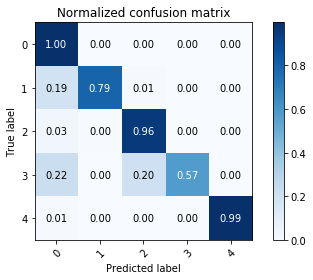

In [3]:
print("Chosen hyperparameters from the best-trained model")
print(best_run)

print(
    "Train acc of best performing model after 10 epochs:",
    best_model.evaluate(inputs["train"], labels["train"], verbose=0)[1],
)
print(
    "Test acc of best performing model after 10 epochs:",
    best_model.evaluate(inputs["test"], labels["test"], verbose=0)[1],
)

test_pred = np.argmax(best_model.predict(inputs["test"]), axis=1)
plot.plot_cm(sparse_labels["test"], test_pred, classes=np.arange(5), normalize=True)